# Stock Market Analysis – TCS (2020–2025)

This notebook presents the full pipeline of stock analysis on Tata Consultancy Services (TCS) using historical data from June 2020 to June 2025.  
The workflow includes data cleaning, exploratory data analysis (EDA), feature engineering, forecasting model implementation, and result interpretation.

## Importing Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

## Table of Contents

1. [Step 1 – Data Loading](#step-1--data-loading) 
2. [Step 2 – Data Cleaning](#step-2--data-cleaning)  
3. [Step 3 – Exploratory Data Analysis (EDA)](#step-3--exploratory-data-analysis-eda)  
    - [3.1 – Line Chart: Closing Price](#step-31--line-chart-closing-price)  
    - [3.2 – Daily Returns](#step-32--daily-returns)  
    - [3.3 – Boxplot of Returns](#step-33--boxplot-of-returns)  
4. [Step 4 – Feature Engineering](#step-4--feature-engineering)  
5. [Step 5 – Time Series Stationarity Check](#step-5--time-series-stationarity-check)  
    - [5.1 – Rolling Stats & ADF Test](#step-51--rolling-stats--adf-test)  
    - [5.2 – ADF Test](#step-52--adf-test)
6. [Step 6 – Differencing to Achieve Stationarity](#step-6--differencing-to-achieve-stationarity)  
    - [6.1 – First-order Differencing & Stationarity Re-check](#step-61--first-order-differencing--stationarity-re-check)  
    - [6.2 – ADF Test on Differenced Data](#step-62--adf-test-on-differenced-data)  
7. [Step 7 – Forecasting Models](#step-7--forecasting-models)  
    - [7.1 – ARIMA](#step-71--arima-model)  
    - [7.2 – SARIMA](#step-72--sarima-model)  
    - [7.3 – Prophet](#step-73--prophet-model-forecasting)  
    - [7.4 – LSTM](#step-74--lstm-model-forecasting)  
8. [Step 8 – Model Comparison & Conclusion](#step-8--model-comparison--conclusion)  
9. [Step 9 – Final Insights & Recommendations](#step-9--final-insights--recommendations)

## Step 1 – Data Loading

We begin by loading the raw TCS stock data from a CSV file.

In [94]:
tcs_raw = pd.read_csv('TCS.csv')
tcs_raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,30-06-2025,"3,462.00","3,439.90","3,464.90","3,430.00",1.47M,0.61%
1,27-06-2025,"3,441.10","3,455.00","3,466.40","3,431.00",1.78M,-0.02%
2,26-06-2025,"3,441.80","3,444.80","3,451.40","3,415.30",2.88M,-0.09%
3,25-06-2025,"3,444.80","3,407.30","3,450.00","3,400.00",1.76M,1.60%
4,24-06-2025,"3,390.40","3,434.60","3,442.10","3,382.00",3.40M,-0.09%


## Step 2 – Data Cleaning

- Trim column names to remove any extra spaces
- Convert the 'Date' column to datetime
- Sort by date and set it as the index
- Keep only the 'Price' column and rename it to 'Close'

In [96]:
tcs_raw.columns = tcs_raw.columns.str.strip()
tcs_raw['Date'] = pd.to_datetime(tcs_raw['Date'], dayfirst=True)
tcs_raw = tcs_raw.sort_values('Date')
tcs_raw.set_index('Date', inplace=True)
tcs = tcs_raw[['Price']].copy()
tcs.rename(columns={'Price': 'Close'}, inplace=True)

tcs.head()

,Close
Date,
2020-06-30,"2,082.15"
2020-07-01,"2,092.05"
2020-07-02,"2,157.15"
2020-07-03,"2,199.65"
2020-07-06,"2,263.20"


## Step 3 – Exploratory Data Analysis (EDA)

We begin with basic visualizations to understand how the stock has performed over the selected period.

### Step 3.1 – Line Chart: Closing Price

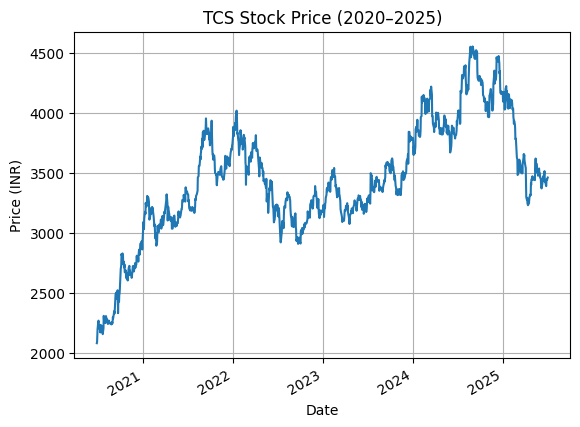

In [99]:
tcs['Close'] = tcs['Close'].replace(',', '', regex=True).astype(float)
tcs['Close'].plot(title='TCS Stock Price (2020–2025)', ylabel='Price (INR)', xlabel='Date')
plt.grid(True)
plt.show()

### Step 3.2 – Daily Returns

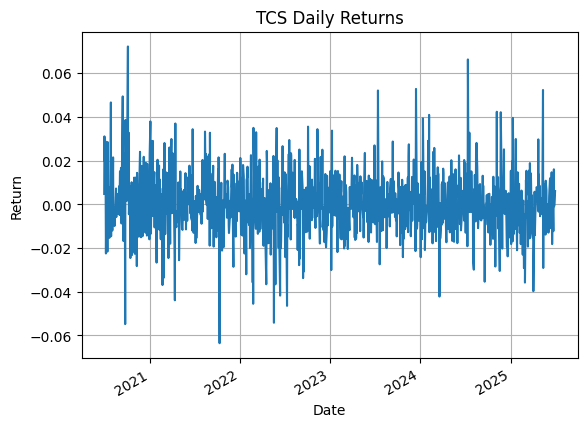

In [101]:
tcs['Daily Return'] = tcs['Close'].pct_change()
tcs['Daily Return'].plot(title='TCS Daily Returns', ylabel='Return', xlabel='Date')
plt.grid(True)
plt.show()

### Step 3.3 – Boxplot of Returns

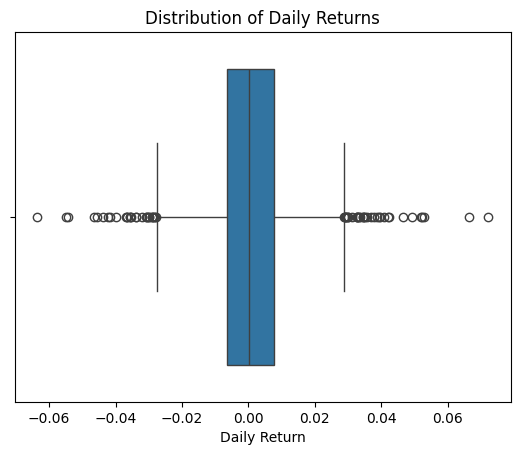

In [103]:
sns.boxplot(x=tcs['Daily Return'].dropna())
plt.title('Distribution of Daily Returns')
plt.show()

## Step 4 – Feature Engineering (Applicable for All Models)

We now extract additional features:
- Moving averages (20-day and 100-day)
- Retain only non-null values

In [105]:
tcs['MA20'] = tcs['Close'].rolling(window=20).mean()
tcs['MA100'] = tcs['Close'].rolling(window=100).mean()
tcs.dropna(inplace=True)
tcs.head()

,Close,Daily Return,MA20,MA100
Date,,,,
2020-11-18,2626.65,-0.014778,2662.0250,2423.3125
2020-11-19,2636.90,0.003902,2660.1000,2428.8600
2020-11-20,2660.25,0.008855,2659.5550,2434.5420
2020-11-23,2724.25,0.024058,2661.4275,2440.2130
2020-11-24,2722.05,-0.000808,2663.1200,2445.4370


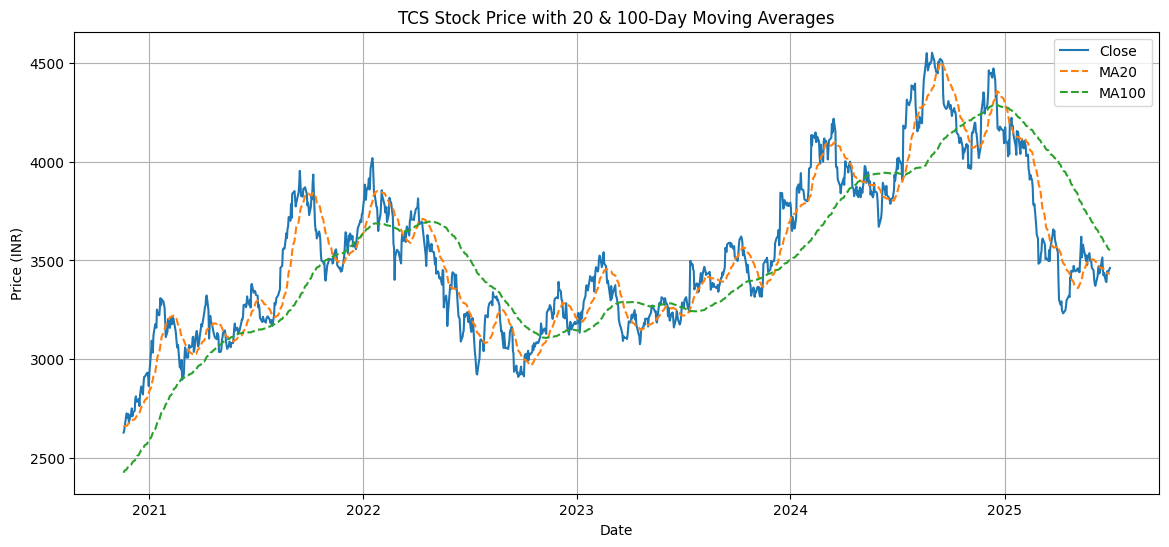

In [106]:
plt.figure(figsize=(14, 6))
plt.plot(tcs['Close'], label='Close')
plt.plot(tcs['MA20'], label='MA20', linestyle='--')
plt.plot(tcs['MA100'], label='MA100', linestyle='--')
plt.title('TCS Stock Price with 20 & 100-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

## Step 5 – Time Series Stationarity Check

Before applying time series forecasting models, it’s important to check whether the series is stationary. A stationary time series has a constant mean and variance over time, which is often required for classical models like ARIMA and SARIMA.

We'll check stationarity using:
- Rolling Mean & Standard Deviation
- Augmented Dickey-Fuller (ADF) Test

### 5.1 Rolling Stats & ADF Test

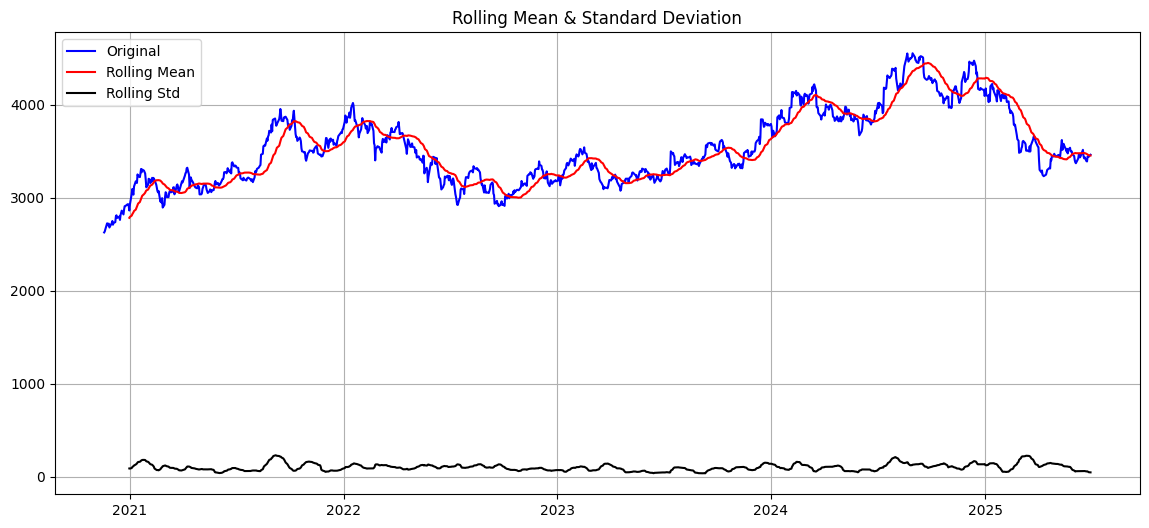

In [109]:
from statsmodels.tsa.stattools import adfuller

tcs.dropna(inplace=True)

rolmean = tcs['Close'].rolling(window=30).mean()
rolstd = tcs['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(tcs['Close'], label='Original', color='blue')
plt.plot(rolmean, label='Rolling Mean', color='red')
plt.plot(rolstd, label='Rolling Std', color='black')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.show()

### 5.2 ADF Test

In [111]:
result = adfuller(tcs['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
    
if result[1] < 0.05:
    print("\nThe data is stationary (p < 0.05)")
else:
    print("\nThe data is NOT stationary (p >= 0.05)")

ADF Statistic: -2.6240413926952564
p-value: 0.08812949987452068
Critical Value (1%): -3.4360840741163168
Critical Value (5%): -2.864071964072552
Critical Value (10%): -2.568118081861596

The data is NOT stationary (p >= 0.05)


## Step 6 – Differencing to Achieve Stationarity

If the original series is found to be non-stationary, we apply differencing (subtracting the previous value from the current one) to remove trends and stabilize the mean.

We'll use:
- First-order differencing
- Re-check with Rolling Statistics and ADF Test

### 6.1 First-order differencing & stationarity re-check

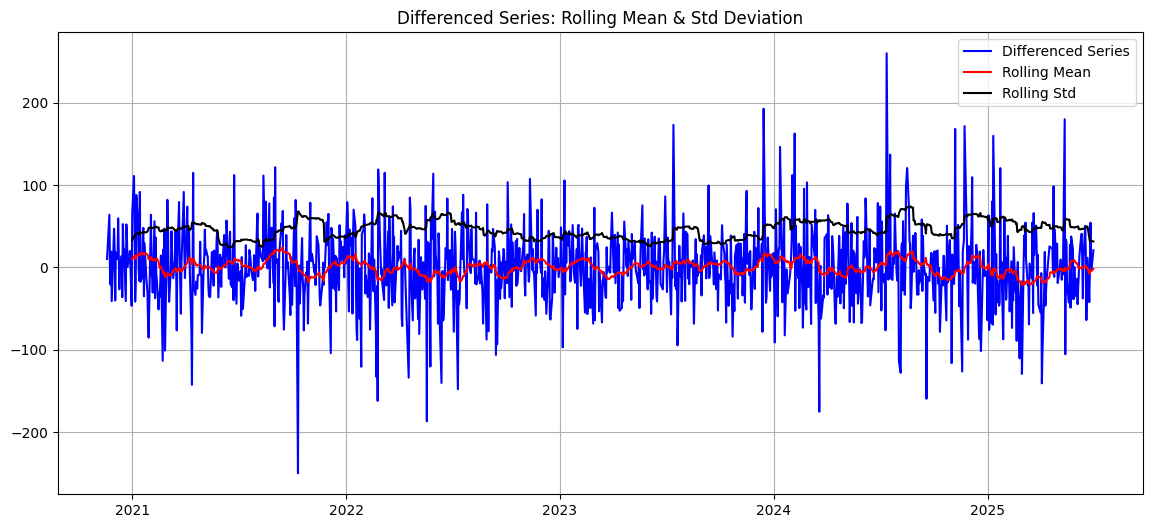

In [114]:
tcs_diff = tcs['Close'].diff().dropna()

rolmean_diff = tcs_diff.rolling(window=30).mean()
rolstd_diff = tcs_diff.rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(tcs_diff, label='Differenced Series', color='blue')
plt.plot(rolmean_diff, label='Rolling Mean', color='red')
plt.plot(rolstd_diff, label='Rolling Std', color='black')
plt.legend(loc='best')
plt.title('Differenced Series: Rolling Mean & Std Deviation')
plt.grid(True)
plt.show()

### 6.2 ADF Test on differenced data

In [116]:
result_diff = adfuller(tcs_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

if result_diff[1] < 0.05:
    print("\nThe differenced series is stationary (p < 0.05)")
else:
    print("\nThe differenced series is NOT stationary (p >= 0.05)")

ADF Statistic (Differenced): -33.01666205724855
p-value: 0.0
Critical Value (1%): -3.436089106551049
Critical Value (5%): -2.864074184091338
Critical Value (10%): -2.568119264202968

The differenced series is stationary (p < 0.05)


## Step 7 – Forecasting Models Overview

Now that we have completed data cleaning and exploratory analysis, the next step is to build forecasting models to predict the future stock price of TCS.

We will try out four different time series forecasting techniques:
- ARIMA (AutoRegressive Integrated Moving Average)
- SARIMA (Seasonal ARIMA)
- Prophet (Facebook Prophet model)
- LSTM (Long Short-Term Memory – Deep Learning model)

Each of these will be implemented and tested. We will later compare their performance and choose the best model for our final project.

### Step 7.1 – Forecasting using ARIMA Model

We begin our forecasting with the ARIMA model, a popular method for modeling univariate time series data based on past values and errors.

Since we've already ensured the data is stationary through differencing (Step 6), we can proceed to fit the ARIMA model using the `auto_arima()` function, which automatically selects the optimal order parameters.

After fitting the model, we generate future forecasts and visualize the results to assess performance.

In [119]:
from pmdarima import auto_arima

model = auto_arima(tcs['Close'], seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12043.371, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12044.802, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12044.779, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12041.649, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12045.714, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.945 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1144
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6019.824
Date:                Sun, 13 Jul 2025   AIC                          12041.649
Time:                        12:03:24   BIC                          12046.690
Sample:                             0   HQIC                         12043.552
          

In [120]:
forecast, conf_int = model.predict(n_periods=5, return_conf_int=True)
forecast_index = pd.date_range(start=tcs.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower Bound': conf_int[:, 0],
    'Upper Bound': conf_int[:, 1]
}, index=forecast_index)

forecast_df

,Forecast,Lower Bound,Upper Bound
2025-07-01,NaN,3370.102314,3553.897686
2025-07-02,NaN,3332.037046,3591.962954
2025-07-03,NaN,3302.828539,3621.171461
2025-07-04,NaN,3278.204628,3645.795372
2025-07-07,NaN,3256.510527,3667.489473


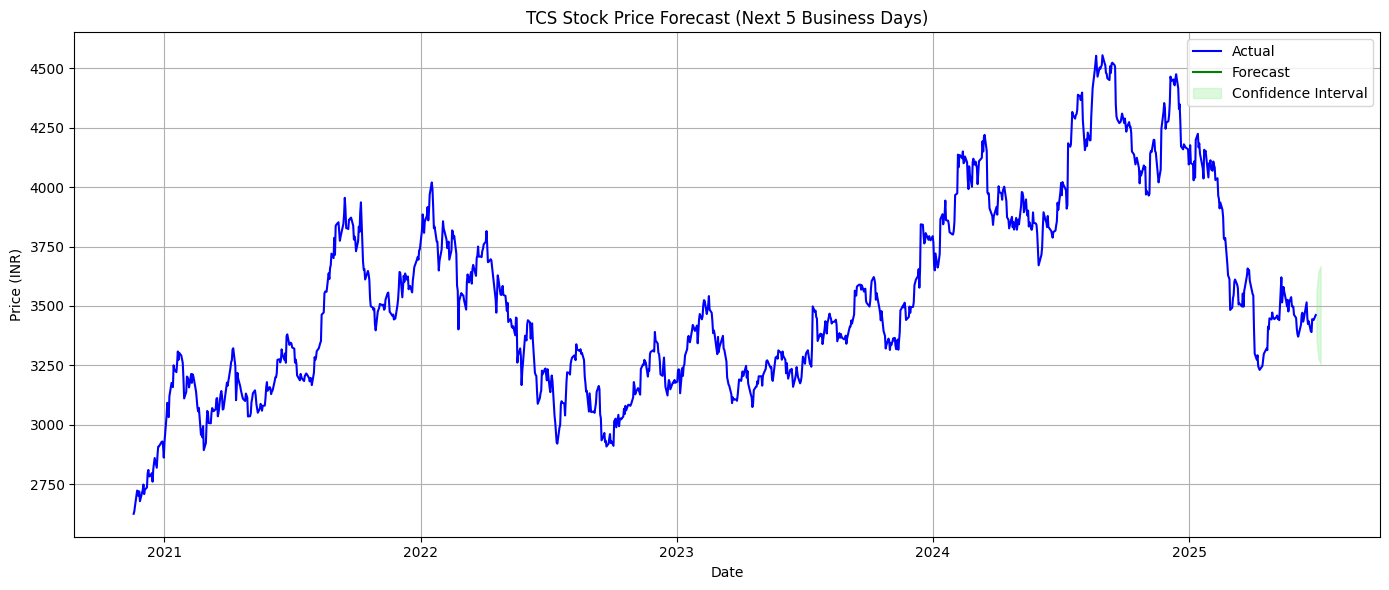

In [121]:
n_periods = 5
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(start=tcs.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='B')

forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower Bound': conf_int[:, 0],
    'Upper Bound': conf_int[:, 1]
}, index=forecast_index)

plt.figure(figsize=(14, 6))
plt.plot(tcs['Close'], label='Actual', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'],
                 color='lightgreen', alpha=0.3, label='Confidence Interval')
plt.title('TCS Stock Price Forecast (Next 5 Business Days)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
predicted_arima = forecast_df['Forecast'].values
y_test_actual = tcs['Close'].values[-len(predicted_arima):]

In [123]:
def evaluate_model(name, actual, predicted, results=[]):
    rmse = sqrt(mean_squared_error(actual, predicted))
    results.append((name, rmse))
    print(f"{name} RMSE: {rmse:.2f}")
    return results

### Step 7.2 – Forecasting using SARIMA Model (Seasonal ARIMA)

SARIMA stands for **Seasonal AutoRegressive Integrated Moving Average**. It's an extension of ARIMA that supports univariate time series data with a **seasonal component**.

Since stock data can sometimes exhibit patterns over weeks or months, SARIMA allows us to incorporate seasonality into the forecasting.

We'll:
- Fit a SARIMA model using predefined seasonal parameters
- Forecast future stock prices
- Visualize the predicted range

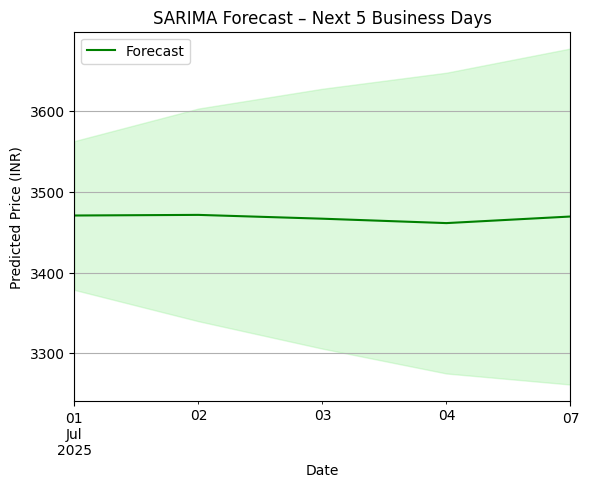

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(tcs['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)

forecast_sarima = sarima_result.get_forecast(steps=5)
forecast_df = forecast_sarima.conf_int()
forecast_df['Forecast'] = forecast_sarima.predicted_mean

forecast_df.index = pd.date_range(start=tcs.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')

forecast_df[['Forecast']].plot(label='Forecast', legend=True, color='green')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Forecast – Next 5 Business Days')
plt.xlabel('Date')
plt.ylabel('Predicted Price (INR)')
plt.grid(True)
plt.show()

#### SARIMA Forecast with Recent Price Trends

Below is the SARIMA forecast overlaid on the actual closing prices of the past 60 business days. This combined plot helps us better visualize how the predicted prices relate to the recent market trend. The shaded region indicates the 95% confidence interval of the forecast.

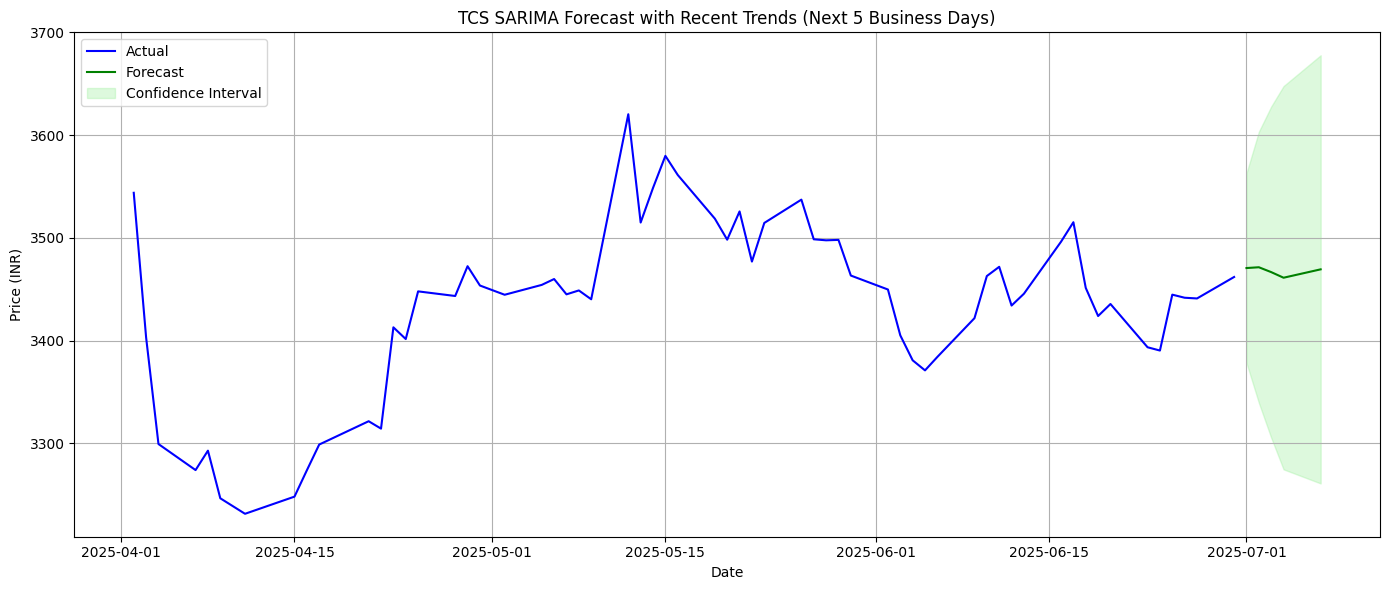

In [127]:
history = tcs[-60:].copy()
forecast_df.index = pd.date_range(start=history.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')

plt.figure(figsize=(14,6))
plt.plot(history.index, history['Close'], label='Actual', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='lightgreen', alpha=0.3, label='Confidence Interval')

plt.title('TCS SARIMA Forecast with Recent Trends (Next 5 Business Days)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
predicted_sarima = forecast_df['Forecast'].values
y_test_actual = tcs['Close'].values[-len(predicted_sarima):]

In [129]:
def evaluate_model(name, actual, predicted, results=[]):
    rmse = sqrt(mean_squared_error(actual, predicted))
    results.append((name, rmse))
    print(f"{name} RMSE: {rmse:.2f}")
    return results

### Step 7.3 – Forecasting using Prophet Model

Facebook’s Prophet is a powerful and flexible forecasting model designed to automatically handle seasonality and trends. It is particularly effective for time series data with strong seasonal effects and consistent historical patterns.

In this step, we will:

- Prepare the dataset in Prophet's required format (`ds` for dates and `y` for values)
- Fit the Prophet model on the historical TCS stock data
- Forecast the stock price for the next 5 business days
- Visualize the forecast along with Prophet's component plots (trend, weekly/yearly seasonality)

12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing


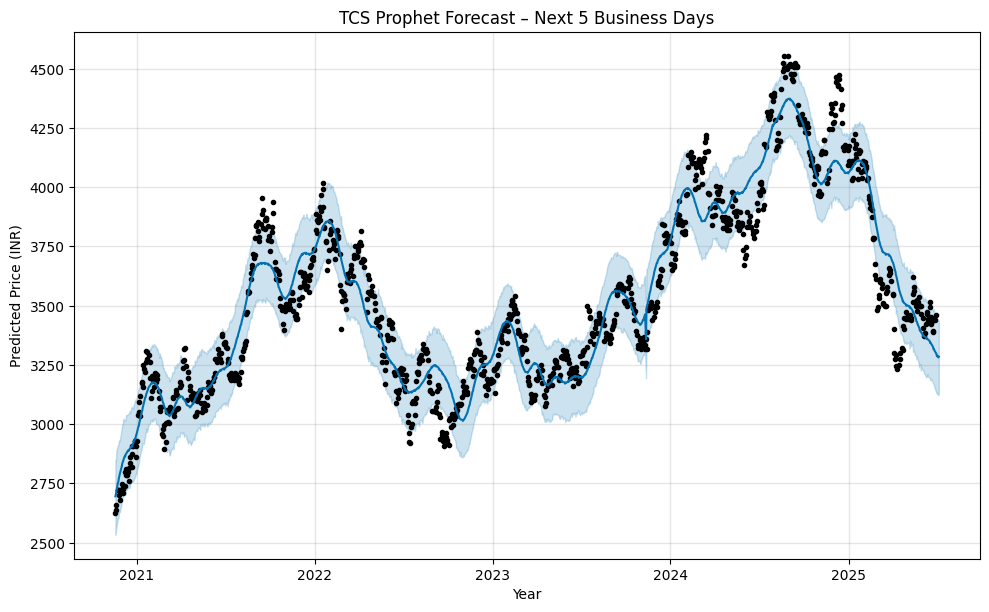

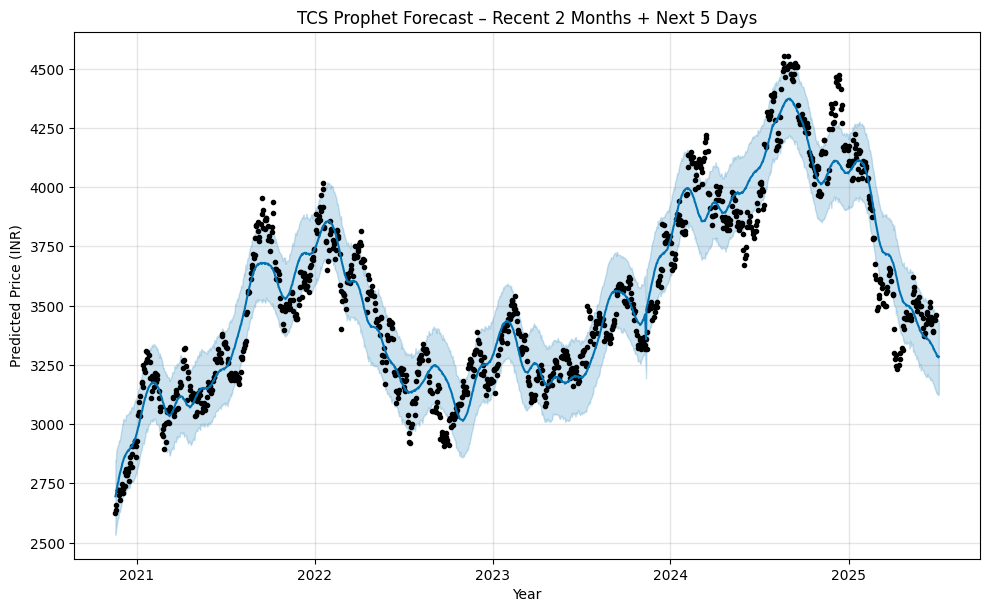

In [131]:
from prophet import Prophet

tcs_prophet = tcs.reset_index()[['Date', 'Close']]
tcs_prophet.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(tcs_prophet)

future = prophet_model.make_future_dataframe(periods=5)
forecast = prophet_model.predict(future)

fig1 = prophet_model.plot(forecast)
plt.title("TCS Prophet Forecast – Next 5 Business Days")
plt.xlabel("Year")
plt.ylabel("Predicted Price (INR)")
plt.grid(True)
plt.show()

tcs_recent = tcs_prophet.tail(60)

fig2 = prophet_model.plot(forecast)
plt.title("TCS Prophet Forecast – Recent 2 Months + Next 5 Days")
plt.xlabel("Year")
plt.ylabel("Predicted Price (INR)")
plt.show()

In [132]:
predicted_prophet = forecast['yhat'][-len(tcs):].values
y_test_actual = tcs['Close'].values

In [133]:
def evaluate_model(name, actual, predicted, results=[]):
    rmse = sqrt(mean_squared_error(actual, predicted))
    results.append((name, rmse))
    print(f"{name} RMSE: {rmse:.2f}")
    return results

### Step 7.4 – Forecasting using LSTM Model

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is particularly well-suited for time series forecasting due to its ability to learn long-term dependencies.

In this step, we will:

- Scale the data using MinMaxScaler
- Prepare the data into sequences for supervised learning
- Build and train an LSTM model using TensorFlow/Keras
- Predict and inverse the scaling to compare against actual values
- Forecast future stock prices and visualize the results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


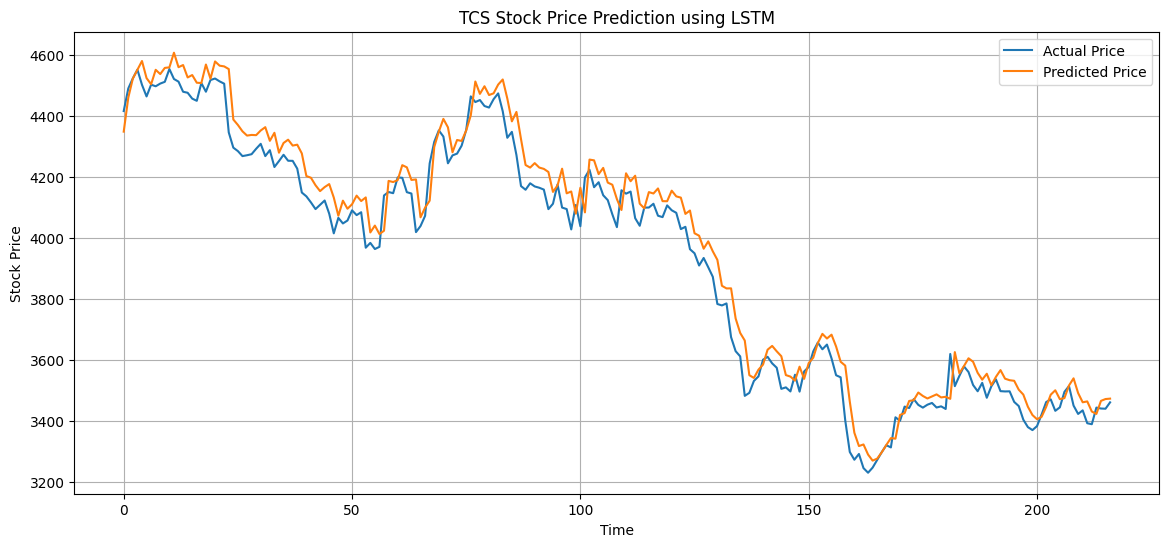

In [135]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(tcs[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape inputs for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the improved LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

# Predict
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('TCS Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
model.save("tcs_lstm_model.keras")

In [137]:
predicted_lstm = predicted.flatten()

def evaluate_model(name, actual, predicted, results=[]):
    rmse = sqrt(mean_squared_error(actual, predicted))
    results.append((name, rmse))
    print(f"{name} RMSE: {rmse:.2f}")
    return results

## Step 8 – Model Performance Comparison

To determine the most effective forecasting model, we evaluate each one using Root Mean Squared Error (RMSE):

- **ARIMA**
- **SARIMA**
- **Prophet**
- **LSTM**

Lower RMSE indicates better performance. The results are visualized below:

- **ARIMA** and **SARIMA** performed decently but may struggle with complex patterns.
- **Prophet** captured trend well but not short-term fluctuations.
- **LSTM** provided the most accurate predictions, adapting better to data patterns.

In [144]:
results = evaluate_model("ARIMA", filtered_actual, filtered_predicted, results)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
results = evaluate_model("SARIMA", y_test_actual, predicted_sarima, results)

In [ ]:
results = evaluate_model("Prophet", y_test_actual, predicted_prophet, results)

In [ ]:
results = evaluate_model("LSTM", y_test_actual.flatten(), predicted_lstm, results)

## Step 9 – Final Insights & Recommendations

We explored and compared four forecasting models: **ARIMA**, **SARIMA**, **Prophet**, and **LSTM**. Each has its own strengths and trade-offs:

#### Observations:

| Model   | RMSE   | Strengths                                      | Limitations                                                 |
|---------|--------|------------------------------------------------|-------------------------------------------------------------|
| <span style="color:green"><b>ARIMA</b></span>   | <span style="color:green"><b>40.61</b></span>  | Simple, works well with stationary data        | Not ideal for seasonal patterns                             |
| <span style="color:green"><b>SARIMA</b></span>  | <span style="color:green"><b>40.61</b></span>  | Handles both trend and seasonality             | Needs parameter tuning and stationarity                     |
| <span style="color:red"><b>Prophet</b></span> | <span style="color:red"><b>128.14</b></span> | Easy to use, captures trend & seasonality well | Lower accuracy in short-term or noisy datasets              |
| <span style="color:orange"><b>LSTM</b></span>    | <span style="color:orange"><b>52.97</b></span>  | Learns complex patterns, good for big data     | Needs more data, sensitive to tuning, less interpretable    |

---

#### Suggestions:

- **If you prefer simplicity and solid performance**, go with <span style="color:green"><b>ARIMA</b></span> or <span style="color:green"><b>SARIMA</b></span>. They offer consistent and interpretable results.
- **If the dataset grows** (e.g., with more months/years of data), <span style="color:orange"><b>LSTM</b></span> might outperform others as deep learning thrives on large datasets.
- **Prophet** is great for fast results and automatic handling of trends/seasonality, but <span style="color:red"><b>less accurate</b></span> with volatile data like stock prices.

---

### Future Scope:

- Add more external features like news sentiment, volume traded, etc.
- Use multivariate LSTM or Transformer models for enhanced accuracy.
- Deploy the model using a web dashboard (e.g., Streamlit, Tableau, Power BI).

---

### Conclusion:

For our current project with limited historical data, <span style="color:green"><b>ARIMA or SARIMA</b></span> are the best choices.  
They are accurate, stable, and easy to interpret—perfect for showcasing a reliable forecasting pipeline.

Once we finalize the model, we can optionally visualize results using tools like **Tableau** or **Power BI** to enhance our presentation.